
# **COMP9414 Artificial Intelligence**
## Assignment 1: Constraint Satisfaction Search

@Authors: **Wayne Wobcke, Alfred Krzywicki, Stefano Mezza**

**Due Date:** Week 5, Friday, October 11, 5.00pm

### Objective

This assignment concerns developing optimal solutions to a scheduling problem inspired by the scenario of hosting a number of visitors to an organization such as a university department. Each visitor must have a number of meetings, however there are both *constraints* on availability (of rooms and hosts), and *preferences* of each visitor for the days and times of each meeting. Some of the constraints are “hard” constraints (cannot be violated in any solution), while the preferences are “soft” constraints (can be satisfied to more or less degree). Each soft constraint has a cost function giving the “penalty” for scheduling the meeting at a given time (*lower* costs are preferred). The aim is to schedule all the required meetings so that the sum total of all the penalties is *minimized*, and all the constraints are satisfied.

More technically, this assignment is an example of a *constraint optimization problem*, a problem that has constraints like a standard Constraint Satisfaction Problem (CSP), but also *costs* associated with each solution. For this assignment, we will use a *greedy* algorithm to find optimal solutions to visitor hosting problems that are specified as text strings. However, unlike the greedy search algorithm described in the lectures on search, this greedy algorithm has the property that it is guaranteed to find an optimal solution for any problem (if a solution exists).

The assignment will use the AIPython code of Poole & Mackworth. You are given code to translate visitor hosting problems specified as text strings into CSPs with a cost, and you are given code for several constraint solving algorithms &ndash; based on domain splitting and arc consistency, and based on depth-first search. The assignment will be to implement some missing procedures and to analyse the performance of the constraint solving methods, both analytically and experimentally.

### Submission Instructions

- This is an individual assignment.

- Submit **this** Jupyter notebook on the CSE give system (or vlab) using the following command: **give cs9414 ass1 ass1.ipynb**

- This means that the Jupyter notebook file **must** be called ``ass1.ipynb``.

- Make sure you set up AIPython (as done below) so the code can be run on either CSE machines or a marker's own machine.

- Do not submit any AIPython code. Hence do not change any AIPython code to make your code run.

- Make sure your notebook runs cleanly (restart the kernel and run each cell to check).

- Do not modify the existing code in this notebook except to answer the questions. Marks will be given as and where indicated.

- If you want to submit additional code (e.g. for generating plots), add that at the end of the notebook.

- **Do not distribute any of this code on the Internet.**

### Late Penalties

Standard UNSW late penalties apply.

### Plagiarism

Remember that ALL work submitted for this assignment must be your own work and no sharing or copying of code or answers is allowed. You may discuss the assignment with other students but must not collaborate on developing answers to the questions. You may use code from the Internet only with suitable attribution of the source. You may not use ChatGPT or any similar software to generate any part of your explanations, evaluations or code. Do not use public code repositories on sites such as github or file sharing sites such as Google Drive to save any part of your work &ndash; make sure your code repository or cloud storage is private and do not share any links. This also applies after you have finished the course, as we do not want next year’s students accessing your solution, and plagiarism penalties can still apply after the course has finished.

All submitted assignments will be run through plagiarism detection software to detect similarities to other submissions, including from past years. You should **carefully** read the UNSW policy on academic integrity and plagiarism (linked from the course web page), noting, in particular, that collusion (working together on an assignment, or sharing parts of assignment solutions) is a form of plagiarism.

Finally, do not use any contract cheating “academies” or online “tutoring” services. This counts as serious misconduct with heavy penalties up to automatic failure of the course with 0 marks, and expulsion from the university for repeat offenders.

### The Visitor Hosting Problem

A CSP for this assignment is a set of variables representing meetings, binary constraints on pairs of meetings, and unary constraints (hard or soft) on meetings. The domains are all working hours in one week, and meetings are all assumed to be 1 hour duration. Days are represented (in the input and output) as strings ‘mon’, ‘tue’, ‘wed’, ‘thu’ and ‘fri’, and times are represented as strings ‘9am’, ‘10am’, ‘11am’, ‘12pm’, ‘1pm’, ‘2pm’, ‘3pm’ and ‘4pm’. The only possible values are a combination of a day and time, e.g. ‘mon 9am’. Each meeting name is a string (with no spaces), and each constraint is hard or soft.

There are three types of constraint:

- **Binary Constraints:** These specify a hard requirement for the relationship between two meetings.
- **Hard Domain Constraints:** These specify hard requirements for the meetings themselves.
- **Soft Domain Constraints:** These constraints are non-critical requirements for a meeting that represent preferences.

Each soft constraint has a function defining the *cost* associated with violating the preference, that the constraint solver must minimize, while respecting all the hard constraints. The *cost* of a solution is simply the sum of the costs for the soft constraints that the solution violates (and is always a non-negative integer).

This is the list of possible constraints for a visitor hosting problem (comments below are for explanation and do **not** appear in the input specification; however, the code we supply *should* work with comments that take up a full line): 

```
# binary constraints
constraint, ⟨m1⟩ before ⟨m2⟩           # m1 must start before m2 starts but m2 could start when m1 finishes
constraint, ⟨m1⟩ same-day ⟨m2⟩         # m1 and m2 must start on the same day
constraint, ⟨m1⟩ one-day-between ⟨m2⟩  # 1 whole day between m1 and m2
constraint, ⟨m1⟩ one-hour-between ⟨m2⟩ # 1 hour between the end of m1 and the start of m2

# hard domain constraints
domain, ⟨m⟩, ⟨day⟩, hard               # must start on day
domain, ⟨m⟩, ⟨time⟩, hard              # must start at time but on any day
domain, ⟨m⟩, ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard    # day-time range for start time; includes day1, time1 and day2, time2
domain, ⟨m⟩, morning, hard             # finishes at or before 12pm 
domain, ⟨m⟩, afternoon, hard           # starts on or after 12pm

# all of these are strictly before/after, not "on or before/after"
domain, ⟨m⟩, before ⟨day⟩, hard        # must be on a previous day
domain, ⟨m⟩, before ⟨time⟩, hard       # must start strictly before time but on any day
domain, ⟨m⟩, before ⟨day⟩ ⟨time⟩, hard # must start strictly before day, time
domain, ⟨m⟩, after ⟨day⟩, hard         # must be on a following day
domain, ⟨m⟩, after ⟨time⟩, hard        # must start after time but on any day
domain, ⟨m⟩, after ⟨day⟩ ⟨time⟩, hard  # must start after day, time and could be on a following day

# soft domain constraints              # cost for scheduling at day, time
domain, ⟨m⟩, early-week, soft          # the number of days from mon to day (0 if day = mon)
domain, ⟨m⟩, late-week, soft           # the number of days from day to fri (0 if day = fri)
domain, ⟨m⟩, early-morning, soft       # the number of hours from 9am to time (0 if time = 9am)
domain, ⟨m⟩, midday, soft              # the number of hours from 12pm to time (0 if time = 12pm)
domain, ⟨m⟩, late-afternoon, soft      # the number of hours from time to 4pm (0 if time = 4pm)
```

The input specification will consist of several “blocks”, listing the meetings, binary constraints, hard unary constraints and soft unary constraints for the given problem. So a declaration of each meeting will be included before it is used in a constraint. A sample input specification is as follows. Comments are for explanation and do **not** have to be included in the input.

```
# two meetings with one binary constraint and the same domain constraints 
meeting, m1
meeting, m2
# one binary constraint
constraint, m1 before m2
# domain constraints
domain, m1, mon, hard
domain, m2, mon, hard
domain, m1, early-morning, soft
domain, m2, early-morning, soft
```

## Preparation

### 1. Set up AIPython

You will need AIPython for this assignment. To find the aipython files, the aipython directory has to be added to the Python path.

Do this temporarily, as done here, so we can find AIPython and run your code (you will not submit any AIPython code).

You can add either the full path (using `os.path.abspath`), or as in the code below, the relative path.

In [1]:
import sys
sys.path.append('aipython') # change to your directory
sys.path # check that aipython is now on the path

['D:\\STUDY_UNSW\\COMP9414\\A1',
 'C:\\Users\\Aufb\\AppData\\Local\\Programs\\Python\\Python311\\python311.zip',
 'C:\\Users\\Aufb\\AppData\\Local\\Programs\\Python\\Python311\\DLLs',
 'C:\\Users\\Aufb\\AppData\\Local\\Programs\\Python\\Python311\\Lib',
 'C:\\Users\\Aufb\\AppData\\Local\\Programs\\Python\\Python311',
 '',
 'C:\\Users\\Aufb\\AppData\\Roaming\\Python\\Python311\\site-packages',
 'C:\\Users\\Aufb\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32',
 'C:\\Users\\Aufb\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib',
 'C:\\Users\\Aufb\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin',
 'C:\\Users\\Aufb\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages',
 'aipython']

### 2. Representation of Day Times

Input and output are day time strings such as 'mon 10am' or a range of day time strings such as 'mon 10am-mon 4pm'.

The CSP will represent these as integer hour numbers in the week, ranging from 0 to 39.

The following code handles the conversion between day times and hour numbers.

In [2]:
# -*- coding: utf-8 -*-
    
""" day_time string format is a day plus time, e.g. Mon 10am, Tue 4pm, or just Tue or 4pm
    if only day or time, returns day number or hour number only
    day_time strings are converted to and from integer hours in the week from 0 to 39
"""
class Day_Time():
    num_hours_in_day = 8
    num_days_in_week = 5
    
    def __init__(self):
        self.day_names = ['mon','tue','wed','thu','fri']
        self.time_names = ['9am','10am','11am','12pm','1pm','2pm','3pm','4pm']
    
    def string_to_week_hour_number(self, day_time_str):
        """ convert a single day_time into an integer hour in the week """
        value = None
        value_type = None
        day_time_list = day_time_str.split()
        if len(day_time_list) == 1:
            str1 = day_time_list[0].strip()
            if str1 in self.time_names: # this is a time
                value = self.time_names.index(str1)
                value_type = 'hour_number'
            else:
                value = self.day_names.index(str1) # this is a day
                value_type = 'day_number'
            # if not day or time, throw an exception
        else:
            value = self.day_names.index(day_time_list[0].strip())*self.num_hours_in_day \
                + self.time_names.index(day_time_list[1].strip())
            value_type = 'week_hour_number'
        return (value_type, value)

    def string_to_number_set(self, day_time_list_str):
        """ convert a list of day-times or ranges 'Mon 9am, Tue 9am-Tue 4pm' into a list of integer hours in the week
            e.g. 'mon 9am-1pm, mon 4pm' -> [0,1,2,3,4,7]
        """
        number_set = set()
        type1 = None
        for str1 in day_time_list_str.lower().split(','):
            if str1.find('-') > 0:
                # day time range
                type1, v1 = self.string_to_week_hour_number(str1.split('-')[0].strip())
                type2, v2 = self.string_to_week_hour_number(str1.split('-')[1].strip())
                if type1 != type2: return None # error, types in range spec are different
                number_set.update({n for n in range(v1, v2+1)})
            else:
                # single day time
                type2, value2 = self.string_to_week_hour_number(str1)
                if type1 != None and type1 != type2: return None # error: type in list is inconsistent
                type1 = type2
                number_set.update({value2})
        return (type1, number_set)
    
    # function for morning constraint: starts 9am, 10am or 11am
    def is_morning(self, week_hour_number):
        h, d = self.hour_day_split(week_hour_number)
        return h in [0, 1, 2]
    
    # function for afternoon constraint: starts 12pm,..., 5pm
    def is_afternoon(self, week_hour_number):
        h, d = self.hour_day_split(week_hour_number)
        return h in [3, 4, 5, 6, 7, 8]
    
    # convert integer hour in week to day time string
    def week_hour_number_to_day_time(self, week_hour_number):
        hour = self.day_hour_number(week_hour_number)
        day = self.day_number(week_hour_number)
        return self.day_names[day]+' '+self.time_names[hour]
    
    # convert integer hour in week to integer day and integer time in day
    def hour_day_split(self, week_hour_number):
        return (self.day_hour_number(week_hour_number), self.day_number(week_hour_number))
    
    # convert integer hour in week to integer day in week
    def day_number(self, week_hour_number):
        return int(week_hour_number / self.num_hours_in_day)
    
    # convert integer hour in week to integer time in day
    def day_hour_number(self, week_hour_number):
        return week_hour_number % self.num_hours_in_day
    
    def __repr__(self):
        day_hour_number = self.week_hour_number % self.num_hours_in_day
        day_number = int(self.week_hour_number / self.num_hours_in_day)
        return self.day_names[day_number]+' '+self.time_names[day_hour_number]

### 3. Constraint Satisfaction Problems with Costs

Since AI Python does not provide the CSP class with an explicit cost, we implement our own class that extends `CSP`.

We also store the cost functions explicitly in the CSP.

In [3]:
from cspProblem import CSP

# implement nodes as CSP problems as nodes with cost functions
class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP var, here a meeting name, to a list of functions for the constraints that apply """    
    def __init__(self, domains, constraints, cost_functions):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.cost_functions = cost_functions
        self.cost = self.calculate_cost()

    # specific to the visitor hosting csp
    def calculate_cost(self):
        """ this is really a function f = path cost + heuristic to be used by the constraint solver """
        cost = 0
        least = 0
        container = []
        hour_day = Day_Time() 
        # Cost function
        for i in self.variables:
            container = []
            for t in self.domains[i]:
                hour,day = hour_day.hour_day_split(t)
                #print(f"Cost functions for variable {i}: {[func.__name__ for func in self.cost_functions[i]]}")
                # calculate the cost for each 
                cost_each = sum(func(day,hour) for func in self.cost_functions[i])
                container.append(cost_each)
            if container:
                least = min(container)
                cost += least
        return cost

    def __repr__(self):
        """ string representation of an arc"""
        return "CSP_with_Cost("+str(list(self.domains.keys()))+':'+str(self.cost)+")"

This formulates a solver for a CSP with cost as a search problem, using domain splitting with arc consistency to define the successors of a node.

In [4]:
from cspProblem import Constraint
from cspConsistency import Con_solver, select, partition_domain 
from searchProblem import Arc, Search_problem
from operator import lt, gt

# rewrites rather than extends Search_with_AC_from_CSP
class Search_with_AC_from_Cost_CSP(Search_problem):
    """ A search problem with domain splitting and arc consistency """
    def __init__(self, csp):
        self.cons = Con_solver(csp) # copy of the CSP with access to arc consistency algorithms
        self.domains = self.cons.make_arc_consistent(csp.domains)
        self.constraints = csp.constraints
        self.cost_functions = csp.cost_functions
        csp.domains = self.domains # after arc consistency
        self.csp = csp

    def is_goal(self, node):
        """ node is a goal if all domains have exactly 1 element """
        return all(len(node.domains[var]) == 1 for var in node.domains)

    def start_node(self):
        return self.csp

    def partition_domain(self, dom, k):
        """partitions domain dom into k.
        """
        dom_list = list(dom)
        length =  len(dom_list)
        # when iteration keeps going there will be finally a case that there is only one values in the domain
        # so we need to keep  that the split will always fit in the size of the domain.
        if k > length:
            k = length  # Reduce k to the size of dom to avoid empty partitions
        

        split = length // k
        remain_part = length % k
        partitions = []
        start_index = 0

        for i in range(k-1):
            end = start_index + split
            partitions.append(set(dom_list[start_index:end]))
            start_index = end
           
        partitions.append(set(dom_list[start_index:]))

        return partitions


    def neighbors(self, node):
        """ returns the neighbouring nodes of the CSP_with_Cost node from domain splitting """
        neighs = []
        var = select(x for x in node.domains if len(node.domains[x]) > 1) # chosen at random
        if var:
            #print(f"Type of node.domains[{var}]:", type(node.domains[var]))
            #print(f"Contents of node.domains[{var}]:", node.domains[var])
            #dom1, dom2 = partition_domain(node.domains[var])
            partitions = self.partition_domain(node.domains[var], 2)
            self.display(2,"Splitting", var, "into", partitions)
            to_do = self.cons.new_to_do(var, None)
            for dom in partitions:
                newdoms = node.domains | {var: dom} # overwrite domain of var with dom
                cons_doms = self.cons.make_arc_consistent(newdoms, to_do)
                if all(len(cons_doms[v]) > 0 for v in cons_doms):
                    # all domains are non-empty
                    # make new CSP_with_Cost node to continue the search
                    csp_node = CSP_with_Cost(cons_doms, self.constraints, self.cost_functions)
                    neighs.append(Arc(node, csp_node))
                else:
                    self.display(2,"...",var,"in",dom,"has no solution")
        return neighs

    
    def heuristic(self, n):
        return n.cost

### 4. Visitor Hosting Constraint Satisfaction Problems

The following code sets up a CSP problem from a given specification.

Hard (unary) domain constraints are applied to reduce the domains of the variables before the constraint solver runs.

In [5]:
# domain specific CSP builder for week schedule
class CSP_builder():
    # list of text lines without comments and empty lines
    type1, default_domain = Day_Time().string_to_number_set('mon 9am-fri 4pm') # should be 0,...,39
    
    # hard unary constraints: domain is a list of values
    def apply_hard_morning(self, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            if not Day_Time().is_morning(val):
                if val in domain: domain.remove(val)
        return domain
    
    def apply_hard_afternoon(self, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            if not Day_Time().is_afternoon(val):
                if val in domain: domain.remove(val)
        return domain
    
    # param is a single value
    def apply_hard_before(self, param_type, param, domain):
        domain_orig = domain.copy()
        param_val = param.pop()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and not h < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and not d < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and not val < param_val:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_hard_after(self, param_type, param, domain):
        domain_orig = domain.copy()
        param_val = param.pop()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and not h > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and not d > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and not val > param_val:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_hard_same_day(self, param_type, param, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and h not in param:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d not in param:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val not in param:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_hard_same_as(self, param_type, param, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and h not in param:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d not in param:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val not in param:
                if val in domain: domain.remove(val)
        return domain

    # soft unary constraints: return cost to break constraint
    def early_morning_soft(self, day, hour):
        return hour
    
    def late_afternoon_soft(self, day, hour):
        return 7 - hour
    
    def midday_soft(self, day, hour):
        # midday is 12pm
        return abs(hour - 3)
    
    def early_week_soft(self, day, hour):
        return day
    
    def late_week_soft(self, day, hour):
        return 4 - day
    
    def no_cost(self, day ,hour):
        return 0
    
    # hard binary constraints
    # one day gap
    def one_day_between(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return abs(d1 - d2) > 1 

    def one_hour_between(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return abs(h1 - h2) > 1 or d1 != d2

    def same_day(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return d1 == d2
    
    # domain is a list of values
    def apply_hard_constraint(self, domain, spec):
        if spec == 'morning':
            return self.apply_hard_morning(domain)
        elif spec == 'afternoon':
            return self.apply_hard_afternoon(domain)
        else:
           dt = spec.strip()
           if dt.find('before') == 0:
               param_type,param = Day_Time().string_to_number_set(dt[len('before'):].strip())
               if len(param) != 1: 
                   return None # before, after should be single value
               return self.apply_hard_before(param_type,param,domain)
           elif dt.find('after') == 0:
               param_type,param = Day_Time().string_to_number_set(dt[len('after'):].strip())
               if len(param) != 1: 
                   return None # before, after should be single value
               return self.apply_hard_after(param_type,param,domain)
           else:
               # if not a keyword, must be day-time
               param_type,param = Day_Time().string_to_number_set(dt)
               return self.apply_hard_same_as(param_type,param,domain)
   
    def get_cost_function(self, spec):
        func_dict = {'early-morning':self.early_morning_soft, 'late-afternoon':self.late_afternoon_soft,
                     'midday':self.midday_soft, 'early-week':self.early_week_soft, 'late-week':self.late_week_soft, 'no-cost':self.no_cost}
        return [func_dict[spec]]
    
    def get_binary_constraint(self, spec):
        tokens = spec.strip().split(' ')
        if len(tokens) < 3: return None # error in specget_CSP_with_Cost
        # meeting1 relation meeting2
        fun_dict = {'before':lt, 'after':gt, 'one-day-between':self.one_day_between, 'one-hour-between':self.one_hour_between, 'same-day':self.same_day}
        return Constraint((tokens[0].strip(), tokens[2].strip()), fun_dict[tokens[1].strip()])
    
    def get_CSP_with_Cost(self, input_lines):
        domains = dict()
        constraints = []
        cost_functions = dict()
        # process each input line of the specification
        for input_line in input_lines:
            func_spec = None
            input_line_tokens = input_line.strip().split(',')
            if len(input_line_tokens) % 2 != 0: 
                return None # must have even number of tokens
            if len(input_line_tokens) < 2: 
                return None
            if input_line_tokens[0].strip() == 'meeting':
                key = input_line_tokens[1].strip()
                domains[key] = self.default_domain.copy() # meeting name and domain
                # get zero cost function for this meeting as default, may add real cost later
                cost_functions[key] = self.get_cost_function('no-cost')
            elif input_line_tokens[0].strip() == 'domain':
                key = input_line_tokens[1].strip()
                for token1 in input_line_tokens[1:]:
                    if token1.strip() == 'hard':
                        # by now, fun_spec string should be set, because spec string comes before hard, soft
                        domains[key] = self.apply_hard_constraint(domains[key], func_spec)
                    elif token1.strip() == 'soft':
                        cost_functions[key] += self.get_cost_function(func_spec)
                    else:
                        func_spec = token1.strip()
            elif input_line_tokens[0].strip() == 'constraint': # binary constraint
                if len(input_line_tokens) < 2: return None # error in spec
                constraints.append(self.get_binary_constraint(input_line_tokens[1].strip()))
            else:
                return None
        return CSP_with_Cost(domains, constraints, cost_functions)
    
def create_CSP_from_spec(spec: str):
    input_lines = list()    
    spec = spec.split('\n')
    # strip comments
    for input_line in spec:
        input_line = input_line.split('#')
        if len(input_line[0]) > 0:
            input_lines.append(input_line[0])
            print(input_line[0])
    # construct initial CSP problem
    csp = CSP_builder()
    csp_problem = csp.get_CSP_with_Cost(input_lines)
    return csp_problem

### 5. Greedy Search Constraint Solver using Domain Splitting and Arc Consistency

Create a GreedySearcher to search over the CSP.

The *cost* function for CSP nodes is used as the heuristic, but is actually a direct estimate of the total path cost function *f* used in A* Search.

In [6]:
from searchGeneric import AStarSearcher

class GreedySearcher(AStarSearcher):
    """ returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    """
    def add_to_frontier(self, path):
        """ add path to the frontier with the appropriate cost """
        value = path.end().cost
        self.frontier.add(path, value)      

Run the GreedySearcher on the CSP derived from the sample input.

In [7]:
# Sample problem specification

sample_spec = """
meeting, m1
meeting, m2
meeting, m3
meeting, m4
constraint, m2 before m4
constraint, m3 one-day-between m2
constraint, m4 before m1
constraint, m1 one-day-between m4
domain, m3, mon 11am-fri 11am, hard
domain, m3, after 11am, hard
domain, m4, wed 3pm-fri 1pm, hard
domain, m4, after tue 12pm, hard
domain, m2, midday, soft
domain, m3, early-morning, soft
"""

In [8]:
# display details (0 turns off)
Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 2
GreedySearcher.max_display_level = 0

def test_csp_solver(searcher):
    final_path = searcher.search()
    if final_path == None:
        print('No solution')
    else:
        domains = final_path.end().domains
        result_str = ''
        for name, domain in domains.items():
            for n in domain:
                result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(n)
        print(result_str[1:]+'\ncost: '+str(final_path.end().cost))
        print(f"number of expanded nodes: {searcher.num_expanded}")
    return searcher.num_expanded,final_path.end().cost

csp_problem = create_CSP_from_spec(sample_spec)
solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
test_csp_solver(solver)

meeting, m1
meeting, m2
meeting, m3
meeting, m4
constraint, m2 before m4
constraint, m3 one-day-between m2
constraint, m4 before m1
constraint, m1 one-day-between m4
domain, m3, mon 11am-fri 11am, hard
domain, m3, after 11am, hard
domain, m4, wed 3pm-fri 1pm, hard
domain, m4, after tue 12pm, hard
domain, m2, midday, soft
domain, m3, early-morning, soft
Splitting m1 into [{32, 33, 34, 35}, {36, 37, 38, 39, 23}]
Splitting m1 into [{32, 33}, {34, 35}]
Splitting m1 into [{32}, {33}]
Splitting m2 into [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}, {11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}]
Splitting m2 into [{0, 1, 2, 3, 4}, {5, 6, 7, 8, 9, 10}]
Splitting m2 into [{0, 1}, {2, 3, 4}]
Splitting m2 into [{2}, {3, 4}]
Splitting m2 into [{3}, {4}]
Splitting m3 into [{19, 20, 21, 22, 23}, {27, 28, 29, 30, 31}]
Splitting m3 into [{19, 20}, {21, 22, 23}]
Splitting m3 into [{19}, {20}]
Splitting m4 into [{22}, {23}]
m1: fri 9am
m2: mon 12pm
m3: wed 12pm
m4: wed 3pm
cost: 3
number of expanded nodes: 13


(13, 3)

### 6. Depth-First Search Constraint Solver

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We need to modify this code to make it compatible with the arc consistency solver.

Run the solver by calling `dfs_solve1` (first solution) or `dfs_solve_all` (all solutions).

In [9]:
num_expanded = 0
display = False

def dfs_solver(constraints, domains, context, var_order, csp):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context\
            """
    global num_expanded, display
    variable = domains.keys()
    hour_day = Day_Time()
    container_cost = {}

    # calculate the cost of each elmenet in the domain for once and use num
    if num_expanded == 0:
        for var in variable:
            sorted_items = {}
            for val in domains[var]:
                hour, day = hour_day.hour_day_split(val)
                cost_each = sum(func(day,hour) for func in csp.cost_functions[var])
                sorted_items[val] = cost_each
                
            if sorted_items:
                sorted_items = dict(sorted(sorted_items.items(), key=lambda item: item[1]))
                sorted_for_choose = list(sorted_items.items())[0]
                first_key, first_value = sorted_for_choose
                container_cost[var] = first_value
                domains[var] = list(sorted_items.keys())  # update domains to be sorted by cost
            else:
                # Handle the case where sorted_items is empty,no valid domain values
                print(f"Warning: No valid domain values for variable {var}")
                return None  
        # sort the container_cost by value
        container_cost = dict(sorted(container_cost.items(), key=lambda item: item[1]))

        # assgin the value to the var_order
        sorted_var_order = list(container_cost.keys())
        var_order = sorted_var_order
        
    
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                yield from dfs_solver(rem_cons, domains, context|{var:val}, var_order[1:], csp)

def dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    return list(dfs_solver(csp.constraints, csp.domains, {}, var_order, csp))

def dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    for sol in dfs_solver(csp.constraints, csp.domains, {}, var_order, csp):
        return sol  # return first one

Run the Depth-First Solver on the sample problem.

In [10]:
def test_dfs_solver(csp_problem):
    solution = dfs_solve1(csp_problem)
    dic = {}
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
            dic[name] = solution[name]
        print(result_str[1:])
    return num_expanded,dic

# call the Depth-First Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_dfs_solver(csp_problem) # set display to True to see number of nodes expanded

meeting, m1
meeting, m2
meeting, m3
meeting, m4
constraint, m2 before m4
constraint, m3 one-day-between m2
constraint, m4 before m1
constraint, m1 one-day-between m4
domain, m3, mon 11am-fri 11am, hard
domain, m3, after 11am, hard
domain, m4, wed 3pm-fri 1pm, hard
domain, m4, after tue 12pm, hard
domain, m2, midday, soft
domain, m3, early-morning, soft
Nodes expanded to reach solution: 20518
m1: fri 9am
m2: mon 12pm
m4: wed 3pm
m3: wed 12pm


(20518, {'m1': 32, 'm2': 3, 'm4': 22, 'm3': 19})

### 7. Depth-First Search Constraint Solver using Forward Checking with MRV Heuristic

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We redefine the `dfs_solver` methods to implement the MRV (Minimum Remaining Values) heuristic using forward checking.

Because the AIPython code is designed to manipulate domain sets, we also need to redefine `can_evaluate` to handle partial assignments.

In [11]:
num_expanded = 0
display = False
def can_evaluate(c, assignment):
    """ assignment is a variable:value dictionary
        returns True if the constraint can be evaluated given assignment
    """
    return assignment != {} and all(v in assignment.keys() and type(assignment[v]) != list for v in c.scope)

def mrv_dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp.
        context is an assignment of values to some of the variables.
        var_order  is  a list of the variables in csp that are not in context.
    """
    global num_expanded, display
    if display:
        print("Context", context)
    to_eval = {c for c in constraints if can_evaluate(c, context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval] # constraints involving unset variables
            var = var_order[0]
            rem_vars = var_order[1:]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                rem_context = context|{var:val}
                # apply forward checking on remaining variables
                if len(var_order) > 1:
                    rem_vars_original = list((v, list(domains[v].copy())) for v in rem_vars)
                    if display:
                        print("Original domains:", rem_vars_original)
                    # constraints that can't already be evaluated in rem_cons
                    rem_cons_ff = [c for c in constraints if c in rem_cons and not can_evaluate(c, rem_context)]
                    for rem_var in rem_vars:
                        # constraints that can be evaluated by adding a value of rem_var to rem_context
                        any_value = list(domains[rem_var])[0]
                        rem_to_eval = {c for c in rem_cons_ff if can_evaluate(c, rem_context|{rem_var: any_value})}
                        # new domain for rem_var are the values for which all newly evaluable constraints hold
                        rem_vals = domains[rem_var].copy()
                        for rem_val in domains[rem_var]:
                            # no constraint with rem_var in the existing context can be violated
                            for c in rem_to_eval:
                                if not c.holds(rem_context|{rem_var: rem_val}):
                                    if rem_val in rem_vals:
                                        rem_vals.remove(rem_val)
                        domains[rem_var] = rem_vals
                        # order remaining variables by MRV
                        rem_vars.sort(key=lambda v: len(domains[v]))
                    if display:
                        print("After forward checking:", list((v, domains[v]) for v in rem_vars))
                if rem_vars == [] or all(len(domains[rem_var]) > 0 for rem_var in rem_vars):
                    yield from mrv_dfs_solver(rem_cons, domains, context|{var:val}, rem_vars)
                # restore original domains if changed through forward checking
                if len(var_order) > 1:
                    if display:
                        print("Restoring original domain", rem_vars_original)
                    for (v, domain) in rem_vars_original:
                        domains[v] = domain
            if display:
                print("Nodes expanded so far:", num_expanded)

def mrv_dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    return list(mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order))

def mrv_dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    for sol in mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run this solver on the sample problem.

In [12]:
def test_mrv_dfs_solver(csp_problem):
    solution = mrv_dfs_solve1(csp_problem)
    dic = {}
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
            dic[name] = solution[name]
        print(result_str[1:])
    return num_expanded,dic

# call the Depth-First MRV Search solver
csp_problem = create_CSP_from_spec(sample_spec)
num_expanded,dic=test_mrv_dfs_solver(csp_problem) # set display to True to see number of nodes expanded



meeting, m1
meeting, m2
meeting, m3
meeting, m4
constraint, m2 before m4
constraint, m3 one-day-between m2
constraint, m4 before m1
constraint, m1 one-day-between m4
domain, m3, mon 11am-fri 11am, hard
domain, m3, after 11am, hard
domain, m4, wed 3pm-fri 1pm, hard
domain, m4, after tue 12pm, hard
domain, m2, midday, soft
domain, m3, early-morning, soft
Nodes expanded to reach solution: 4
m4: wed 3pm
m1: fri 9am
m3: mon 12pm
m2: wed 9am


## Assignment

**Name:** Boyang He

**zID:**  z5575322

### Question 1 (4 marks)

Consider the search spaces for the CSP solvers &ndash; domain splitting with arc consistency and the DFS solver (without forward checking).

- Describe the search spaces informally in terms of start state, successor functions and goal state(s) (1 mark)
- What is the branching factor and maximum depth to find any solution for the two algorithms (ignoring costs)? (1 mark)
- What is the worst case time and space complexity of the two search algorithms (give the general form)? (1 mark)
- Give an example of a problem that is *easier* for the domain splitting with arc consistency solver than it is for the DFS solver, and explain why (1 mark)

__Answers for Question 1__

### 1.
#### Domain Splitting with Arc Consistency:

**Start state**: All of the domains for the variables are reasonable and complete, and none of the variables have been assigned values.In our assignment,the start state is all of the meetings haven't been assgined meeting time and all of its domains are complete and reasonable.

**Successor functions**: First, split up the domain of a variable into several parts and then assign a value to it from one part. At the same time, reduce the domains of other variables according to arc consistency by deleting the values which violate the constraints. Arc consistency will then spread to other domains. Finally, check whether the current assigned values have violated any constraints.In the assignment,we frist split up the domains of the meetings into several parts.Then we will use the arc consitency to eliminate tge constraints which would lead to conflicts.And repeat the procedures until all of the meetings have been assgined values.

**Goal state**: All of the variables have been assigned values which satisfy the hard constraints, and no values violate any constraints.All of the meetings have been assgined values which do not lead to conflicts.

#### DFS without forward checking
**Start state**: All of the domains for the variables are reasonable and complete, and none of the variables have been assigned values.In our assignment,the start state is all of the meetings haven't been assgined meeting time and all of its domains are complete and reasonable.

**Successor functions**:At each step, we choose a variable and assgin the value to it.And do DFS on it,we continue assigning values to later variables until we meet up a conflic.Then we do backtrack when we meet conflicts and try a different assignment to the variable We will do the above iterally until we find the goal.

**Goal state**: All of the variables have been assigned values which satisfy the hard constraints, and no values violate any constraints.All of the meetings have been assgined values which do not lead to conflicts.
### 2.
#### Domain Splitting with Arc Consistency:
**Branching factor**: Since branching factor is how many possible choices are there in a given state.In our question,each meeting can be held in 8 of the 5 working days (Monday to Friday) of the week (9am to 4pm).So the basic branching factor is 40 when there is no constraints(which is the worst case).But when the constraint is added to the problem,the factor become dynamic and would change according to the constraint.

**Maximum depth**: In this question maximum depth equals to the number of meetings that need to be assigned.If the number of meetings is n,then n is the maximum depth.

#### DFS without forward checking
**Branching factor**: It is dynamic and is depend on the number of choices in its domain.In this question the basic branching factor is 40 when there is no constraints.And would change according to the constraint.And for the worst case,the branching factor for DFS without forward checking is 40.

**Maximum depth**: In this question maximum depth equals to the number of meetings that need to be assigned.If the number of meetings is n,then n is the maximum depth.

### 3.
#### Domain Splitting with Arc Consistency:
**We assume b is the domains of the meeting and n is the number of meetings.**
**Time complexity**: In the worst case，it needs to go through every possibility in each domain.So for each variable,the size of its domain is b and there are n variables.So the time complexity is O(b**n)

**Space complexity**: O(b**n)

#### DFS without forward checking
**Time complexity**: In the worst case,it will go through every nodes in the tree O(b**n)

**Maximum depth**:O(n)

### 4.
There are three variablesA,B,C,whose domains are {1,2,3,4}.And the constraints is A<B,B<C.The arc consistency will eliminate the domains according to the constraints which will reduce the workload.But for DFS it will traverse the entire tree and will only backtrack when they meet the conflicts.It will increase the searching  cost.

### Question 2 (5 marks)

Define the *cost* function for a visitor hosting CSP (i.e. a node in the search space for domain splitting and arc consistency) as the total cost of the soft constraints violated for all of the variables, assuming that each variable is assigned the best possible value from its domain, where the “best” value for a variable *v* is the one that has the lowest total cost to violate the soft constraints for that variable *v* &ndash; note that there can be more than one soft constraint applying to *v* so we add up the costs of violating each of those constraints to define the best value for *v*.

- Implement the cost function in the indicated cell and place a copy of the code below (3 marks)
- What is its computational complexity (give a general form)? (1 mark)
- Show that the cost function *f* never decreases along a path, and explain why this means the search algorithm is optimal (1 mark)

In [13]:
# Code for Question 2
def calculate_cost(self):
        """ this is really a function f = path cost + heuristic to be used by the constraint solver """
        cost = 0
        least = 0
        container = []
        hour_day = Day_Time() 
        # Cost function
        for i in self.variables:
            container = []
            # Check whether the function has constraints for i or not
            #if i not in self.cost_functions or not self.cost_functions[i]:
                #continue
            for t in self.domains[i]:
                hour, day = hour_day.hour_day_split(t)
                # calculate the cost for each 
                cost_each = sum(func(day,hour) for func in self.cost_functions[i])
                container.append(cost_each)
            if container:
                least = min(container)
                cost += least
        return cost

__Answers for Question 2__

### 2.
We assume that there are n variables and the domain for the variables is i,and the number of cost function for each value is b.So the compuutational complexity is O(n×b×i) which is O(nbi).

### 3.
The cost function f never decreases along a path because the algorithm is a procedure of keep moving forward.If the new step doesn't violate any constrainnts the cost would remain the same and if it does,the extra cost for this step would be added to the cost function f.So it never decreases along a path

The algorithm is optimal because the cost function f doesn't decrease at each step.And at each step the variable that we choose cost least amoung all the others.So every step of the algorirhm is optimal at that stage.So when we add them together we will lead to the all time optimal.

### Question 3 (4 marks)

Perform an empirical evaluation of the domain splitting CSP solver using the cost function defined as above compared to using no cost function (i.e. the zero cost function, as originally defined in the above cell). Use the *average number of nodes expanded* as a metric to compare the two algorithms. 

- Write a function `generate_problem(n)` that takes an integer `n` and generates a problem specification with `n` meetings and a random set of hard and soft constraints in the correct format for the constraint solvers (2 marks)

Run the CSP solver (with and without the cost function) over a number of problems of size `n` for a range of values of `n`.

- Plot the performance of the two constraint solving algorithms on the above metric against `n` (1 mark)
- Quantify the performance gain (if any) achieved by the use of this cost function (1 mark)

In [14]:
import random    
def generate_problem(n):
    problem = []
    days = ['mon', 'tue', 'wed', 'thu', 'fri']
    times = ['9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm']
    str_problem = ''

    # Meetings
    for i in range(1, n + 1):
        meetings = f'meeting, m{i}'
        problem.append(meetings)

    # Binary constraints
    for i in range(n):
        first, second = random.sample(range(1, n + 1), 2)
        m1, m2 = f'm{first}', f'm{second}'
        hard_constraint_type = random.choice(['before', 'same-day', 'one-day-between', 'one-hour-between'])
        problem.append(f"constraint, {m1} {hard_constraint_type} {m2}")

    # Hard constraints
    for i in range(n // 2):
        first = random.sample(range(1, n + 1), 1)[0]
        m = f'm{first}'
        constraint_type = random.choice(['day', 'time', 'day-time', 'morning', 'afternoon'])
        bf_af_choose = random.choice(['before', 'after'])

        # Randomly choose a day and time for the before/after constraints
        day = random.choice(days)
        time = random.choice(times)
        dtchoice = random.choice([f'{day}', f'{time}'])
        dtselection = random.choice(['pure', 'npure'])
        combination = f"{day} {time}"

        if constraint_type == 'day':
            # must start on a specific day
            problem.append(f"domain, {m}, {day}, hard")

        elif constraint_type == 'time':
            # must start at a specific time
            problem.append(f"domain, {m}, {time}, hard")

        elif constraint_type == 'day-time':
            # must start within a day-time range, ensuring day1 <= day2 and time1 < time2 when day1 == day2
            day1, day2 = random.choice(days), random.choice(days)
            time1, time2 = random.choice(times), random.choice(times)
            if days.index(day1) > days.index(day2) or (days.index(day1) == days.index(day2) and times.index(time1) > times.index(time2)):
                day1, day2 = day2, day1
                time1, time2 = time2, time1
            problem.append(f"domain, {m}, {day1} {time1}-{day2} {time2}, hard")

        elif constraint_type == 'morning':
            # finish at or before 12pm
            problem.append(f"domain, {m}, morning, hard")

        elif constraint_type == 'afternoon':
            # start at or after 12pm
            problem.append(f"domain, {m}, afternoon, hard")

        if dtselection == 'pure':
            if bf_af_choose == 'before':
                while (dtchoice == 'mon' or dtchoice == '9am'):
                    day = random.choice(days)
                    time = random.choice(times)
                    dtchoice = random.choice([f'{day}', f'{time}'])
                problem.append(f"domain, {m}, {bf_af_choose} {dtchoice}, hard")

            elif bf_af_choose == 'after':
                while (dtchoice == 'fri' or dtchoice == '4pm'):
                    day = random.choice(days)
                    time = random.choice(times)
                    dtchoice = random.choice([f'{day}', f'{time}'])
                problem.append(f"domain, {m}, {bf_af_choose} {dtchoice}, hard")
                
        elif dtselection == 'npure':
            if bf_af_choose == 'before':
                while day == 'mon' and time == '9am':
                    day = random.choice(days)
                    time = random.choice(times)
                problem.append(f"domain, {m}, {bf_af_choose} {combination}, hard")

            elif bf_af_choose == 'after':
                while day == 'fri' and time == '4pm':
                    day = random.choice(days)
                    time = random.choice(times)
                problem.append(f"domain, {m}, {bf_af_choose} {combination}, hard")

    # Soft constraints
    for i in range(n // 2):
        first = random.sample(range(1, n + 1), 1)[0]
        m = f'm{first}'
        soft_constraint_type = random.choice(['early-week', 'late-week', 'early-morning', 'midday', 'late-afternoon'])
        problem.append(f"domain, {m}, {soft_constraint_type}, soft")

    # Convert the problem list to a string
    for line in problem:
        str_problem += f'{line}\n'

    return str_problem

print(generate_problem(3))


meeting, m1
meeting, m2
meeting, m3
constraint, m3 same-day m2
constraint, m3 one-day-between m2
constraint, m1 before m2
domain, m1, 4pm, hard
domain, m1, before thu, hard
domain, m2, early-week, soft



### Question 3/2

In [15]:
# Question 3/2
import matplotlib.pyplot as plt
import numpy as np

def compare_with_and_without_cost(csp_problem):
    """
    Compare CSP solving with cost and with no cost.
    """
    # With cost
    solver_with_cost = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
    expanded_with_cost_nodes,cost1= test_csp_solver(solver_with_cost)
    
    # Without cost
    def apply_no_cost_to_all(csp):
        """ Help clean up all the constraints """
        for var in csp.cost_functions:
            csp.cost_functions[var] = [CSP_builder().no_cost]
        return csp

    # Apply no_cost to all variables in CSP
    csp_problem_no_cost = apply_no_cost_to_all(csp_problem)
    solver_without_cost = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem_no_cost))
    expanded_without_cost,cost2 = test_csp_solver(solver_without_cost)

    return expanded_without_cost, expanded_with_cost_nodes

def test_and_plot(n):
    # create and plot 
    avg_with_nodes = []
    avg_without_nodes = []
    for i in range(2,n):
        sample_spec=generate_problem(i)
        csp_problem = create_CSP_from_spec(sample_spec)
    
        # make comparisions
        a,b=compare_with_and_without_cost(csp_problem)
        avg_without_nodes.append(a)
        avg_with_nodes.append(b)
    
    sumwith = sum(avg_without_nodes)
    sumwithout = sum(avg_with_nodes)

    avg_with_nodes = sumwith/len(avg_with_nodes)
    avg_without_nodes = sumwithout/len(avg_without_nodes)


    # plot 
    plt.text(1, avg_with_nodes, f'{avg_with_nodes:.2f}', ha='center', va='bottom')
    plt.text(2, avg_without_nodes, f'{avg_without_nodes:.2f}', ha='center', va='bottom')
    plt.bar([1,2],[avg_with_nodes,avg_without_nodes],color=['b','y'])
    plt.xticks([1,2],['With Cost','Without Cost'])
    plt.ylabel('Average number of nodes expanded')
    plt.title('Comparison of Average Expanded Nodes With and Without Cost')
    plt.show()

    
                

meeting, m1
meeting, m2
constraint, m2 before m1
constraint, m1 one-hour-between m2
domain, m2, fri, hard
domain, m2, before fri 2pm, hard
domain, m2, late-afternoon, soft
Splitting m1 into [{33, 34, 35}, {36, 37, 38, 39}]
Splitting m1 into [{36, 37}, {38, 39}]
Splitting m1 into [{38}, {39}]
Splitting m2 into [{32, 33}, {34, 35, 36}]
Splitting m2 into [{34}, {35, 36}]
Splitting m2 into [{35}, {36}]
m1: fri 3pm
m2: fri 1pm
cost: 3
number of expanded nodes: 7
Splitting m1 into [{33, 34, 35}, {36, 37, 38, 39}]
Splitting m1 into [{34}, {35}]
m1: fri 11am
m2: fri 9am
cost: 0
number of expanded nodes: 3
meeting, m1
meeting, m2
meeting, m3
constraint, m3 one-hour-between m2
constraint, m3 same-day m2
constraint, m3 one-hour-between m1
domain, m1, morning, hard
domain, m1, before 3pm, hard
domain, m1, midday, soft
Splitting m1 into [{0, 1, 2, 8, 9, 10, 16}, {32, 33, 34, 17, 18, 24, 25, 26}]
Splitting m1 into [{0, 1, 2}, {8, 9, 10, 16}]
Splitting m1 into [{0}, {1, 2}]
Splitting m1 into [{1}, {2

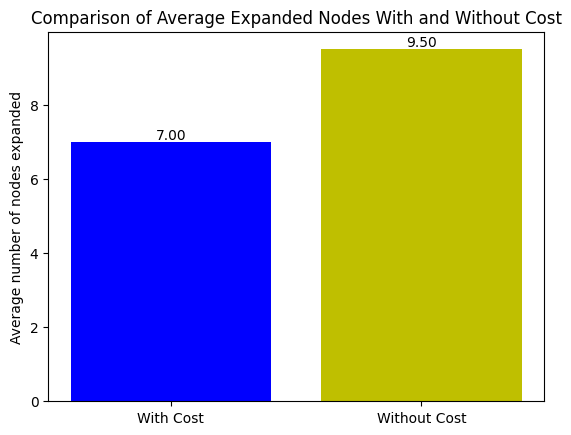

In [16]:
random.seed(38)
test_and_plot(4)

__Answers for Question 3__

#### Question3.2
The performance is displayed in the chart above.We compare the domain splitting with and without cost function.
#### Question3.3
According to the chart above we can easily conclude that the algorithm with cost behaves better than the one without cost since it expands the nodes as small as possible.The difference between the average nodes is quite small.And the performance Gain is nearly 30 percent.It means that the algorithm with cost function would do well in assigning the meeting.



### Question 4 (5 marks)

Compare the Depth-First Search (DFS) solver to the Depth-First Search solver using forward checking with Minimum Remaining Values heuristic (DFS-MRV). For this question, ignore the costs associated with the CSP problems. 

- What is the worst case time and space complexity of each algorithm? (1 mark)
- What are the properties of the search algorithms (completeness, optimality)? (1 mark)
- Give an example of a problem that is *easier* for the DFS-MRV solver than it is for the DFS solver, and explain why (1 mark)
- Empirically compare the quality of the first solution found by DFS and DFS-MRV compared to the optimal solution (1 marks)
- Empirically compare DFS-MRV with DFS in terms of the number of nodes expanded (1 mark)

For the empirical evaluations, run the two algorithms on a variety of problems of size `n` for varying `n`. Note that the domain splitting CSP solver with costs should always find an optimal solution.

__Answers for Question 4__

### Q4/1
**Assume we have n meetings and the size of the domain for each is d**

**DFS solver**

Time complexity:For the worst case it needs to go through every possible variable and their assignment combination.So its time complexity is O($d^n$).

Space complexity:For the worst case,it will explore and store the searching path which is n here.Since it needs to find a solution for all of the varible.So the maximum depth here is n.So the sapce complexity is O(n).

**DFS solver using forward checking**

Time complexity:Although in this algorithm,forward checking would help eliminate the domains according to the given constraints,but in the worst case it still need to go through every possiblity in each domain.So the time complexity here is still O($d^n$).

Space complexity:For the space complexity here，according to the foreward checking algorithm,it will eliminate the domains for the remain.So the function will not only deal with the depth search as DFS before,but also deal with the domain elimination.So the complexity here is O(d)+O(n) which is O(d+n).

### Q4/2
**DFS solver**

**It is not complete and is not optimal.** Since if the search space has a circle or it is unlimit,it will never find a solution to the problem.And since dfs doesn't care about the cost,so even it find a solution ,the solution would not be optimal.

**DFS solver using forward checking**

**It is complete and is not optimal.** Since it has backtrack algorithm,so it will go back and try every possible path until find all solutions(if the problem is solvable).So it is complete since it could definitely find an answer.But it is not optimal since it would not take cost into considerations,so the solution that it finds would not be the one with least cost.

### Q4/3
There are three variablesA,B,C,whose domains are {1,2,3,4}.And the constraints is A<B,B<C.For DFS it will first set up A as 1 and B as 1 then it will find out conflict happend,then it will go back to B and reset it to b as 2.And then continue to C.It will meet many conflits and assgin the values to varible all over again until it meets the constraint.It would cost much time and resource.And for  DFS-MRV solver if A is assgined value1 ,then the domain of B will be eliminated to {2,3,4} since only in this case the assignment of B would not violated the constraint.Then B would be assgined value 2,in this case the running time gets short.And it is easier for DFS-MRV solver to find out the solution.




meeting, m1
meeting, m2
constraint, m1 one-day-between m2
constraint, m2 one-hour-between m1
domain, m2, morning, hard
domain, m2, after thu, hard
domain, m2, early-week, soft
Nodes expanded to reach solution: 2
m1: mon 9am
m2: fri 9am
Nodes expanded to reach solution: 2
m2: fri 9am
m1: mon 9am
Splitting m1 into [{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}, {12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}]
Splitting m1 into [{0, 1, 2, 3, 4, 5}, {6, 7, 8, 9, 10, 11}]
Splitting m1 into [{0, 1, 2}, {3, 4, 5}]
Splitting m1 into [{0}, {1, 2}]
Splitting m2 into [{32}, {33, 34}]
m1: mon 9am
m2: fri 9am
cost: 4
number of expanded nodes: 6
meeting, m1
meeting, m2
meeting, m3
constraint, m3 one-day-between m2
constraint, m3 one-day-between m2
constraint, m3 same-day m1
domain, m3, morning, hard
domain, m3, before fri, hard
domain, m2, early-morning, soft
Nodes expanded to reach solution: 29
m1: mon 9am
m2: wed 9am
m3: mon 9am
Nodes expanded to reach solution: 3
m3: mon 9am
m1: mon 9am
m2: wed 9am
Spl

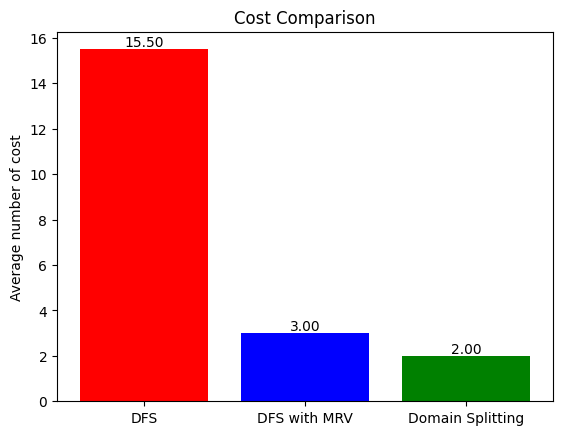

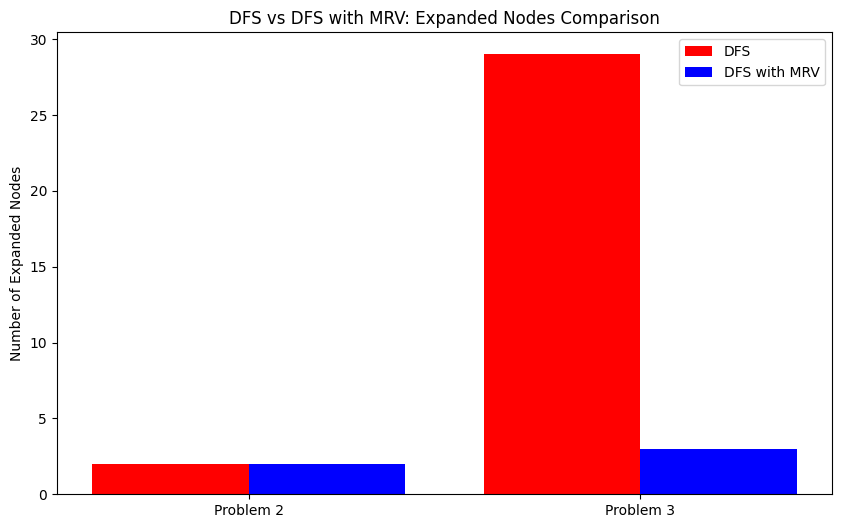

In [17]:
def cal_cost(dic):
    hour_day = Day_Time()
    total_cost = 0
    total_cost = 0
    for i in dic:
        container = []
        # deal with the domain
        t = dic[i]
        hour, day = hour_day.hour_day_split(t)
        # calculate the soft cost
        cost_each = sum(func(day, hour) for func in csp_problem.cost_functions[i])
        container.append(cost_each)
        total_cost += sum(container)
    
    return total_cost


def comparison(n):
    cost_DFS = []
    cost_MRV = []
    cost_GR =[]
    expanded_DFS = []
    expanded_MRV = []
    avg_DFS =0
    avg_MRV =0
    avg_GR =0
    for i in range(2,n+1):
        # DFS without MRV
        problem = generate_problem(i)
        csp_problem = create_CSP_from_spec(problem)

        num1,dic1 = test_dfs_solver(csp_problem) # set display to True to see number of nodes expanded
        cost1 = cal_cost(dic1)
        cost_DFS.append(num1)
        expanded_DFS.append(num1)  # 添加expanded nodes
        
        # DFS with MRV
        num2,dic2= test_mrv_dfs_solver(csp_problem) # set display to True to see number of nodes expanded
        cost2 = cal_cost(dic2)
        cost_MRV.append(cost2)
        expanded_MRV.append(num2)  # 添加expanded nodes
        
        #Optimal function
        solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
        num3,cost3 = test_csp_solver(solver)
        cost_GR.append(cost3)
        
        avg_DFS = sum(cost_DFS)/len(cost_DFS)
        avg_MRV = sum(cost_MRV)/len(cost_MRV)
        avg_GR = sum(cost_GR)/len(cost_GR)
    
    return avg_DFS,avg_MRV,avg_GR,expanded_DFS,expanded_MRV

# plot cost
random.seed(37)
avg_DFS,avg_MRV,avg_GR,expanded_DFS,expanded_MRV = comparison(3)
plt.text(1, avg_DFS, f'{avg_DFS:.2f}', ha='center', va='bottom')
plt.text(2, avg_MRV, f'{avg_MRV:.2f}', ha='center', va='bottom')
plt.text(3, avg_GR, f'{avg_GR:.2f}', ha='center', va='bottom')
plt.bar([1,2,3],[avg_DFS,avg_MRV,avg_GR],color=['r','b','g'])
plt.xticks([1,2,3],['DFS','DFS with MRV','Domain Splitting'])
plt.ylabel('Average number of cost')
plt.title('Cost Comparison')
plt.show()

# plot nodes
plt.figure(figsize=(10, 6))

# plot Expanded Nodes comparision
plt.bar([i - 0.2 for i in range(len(expanded_DFS))], expanded_DFS, width=0.4, color='r', align='center', label='DFS')
plt.bar([i + 0.2 for i in range(len(expanded_MRV))], expanded_MRV, width=0.4, color='b', align='center', label='DFS with MRV')

plt.xticks([i for i in range(len(expanded_DFS))], [f'Problem {i+2}' for i in range(len(expanded_DFS))])
plt.ylabel('Number of Expanded Nodes')
plt.title('DFS vs DFS with MRV: Expanded Nodes Comparison')
plt.legend()
plt.show()

### Q4/4
As is shown in the graph,Using DFS violates a lot of constraints which lead to a higher cost.The quality of the solution for DFS is not good enough.And for for DFS with MRV ,its cost is nearly to Domain Splitting algorithm.It means that with the help of heuristics, solutions can be found at much lower cost than DFS.And Domain Splitting algorithm is still the optiam algorithm,it finds the solution with the lowest cost.

### Q4/5
As is shown in the result above,we can conclude that DFS-MRV behaves better than simply using DFS.Since DFS-MRV expands significantly fewer nodes than DFS. It means that DFS-MRV behaves much better than DFS.And the difference becomes larger with the increase of n since MRV have already eliminate the domains and start choosing from the shortest domain.It will reduce the searching time and at the same time lower the cost of the search.Hence, DFS-MRV is much better suited for large-scale CSPs.

### Question 5 (4 marks)

The DFS solver chooses variables in random order, and systematically explores all values for those variables in no particular order.

Incorporate costs into the DFS constraint solver. Similar to the cost function for the domain splitting solver, for a given variable *v*, the cost of assigning the value *val* to *v* is the total cost of violating all the soft constraints associated with *v* for the value *val*. The *minimum cost* for *v* is the lowest cost from amongst the values in the domain of *v*. The DFS solver should choose the variable *v* with lowest minimum cost, and explore its values in order of cost from lowest to highest.

- Implement this behaviour by modifiying the code in `dfs_solver` and place a copy of the code below (2 marks)
- Empirically compare the performance of DFS with and without these heuristics (2 marks)

For the empirical evaluations, again run the two algorithms on a variety of problems of size `n` for varying `n`.

In [18]:
# Code for Question 5
def dfs_solver(constraints, domains, context, var_order, csp):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context\
            """
    global num_expanded, display
    variable = domains.keys()
    hour_day = Day_Time()
    container_cost = {}

    # calculate the cost of each elmenet in the domain for once and use num
    if num_expanded == 0:
        for var in variable:
            sorted_items = {}
            for val in domains[var]:
                hour, day = hour_day.hour_day_split(val)
                cost_each = sum(func(day,hour) for func in csp.cost_functions[var])
                sorted_items[val] = cost_each
                
            if sorted_items:
                #got the lambda idea from https://www.geeksforgeeks.org/python-sort-python-dictionaries-by-key-or-value/
                sorted_items = dict(sorted(sorted_items.items(), key=lambda item: item[1]))
                sorted_for_choose = list(sorted_items.items())[0]
                first_key, first_value = sorted_for_choose
                container_cost[var] = first_value
                domains[var] = list(sorted_items.keys())  # update domains to be sorted by cost
            else:
                # Handle the case where sorted_items is empty,no valid domain values
                print(f"Warning: No valid domain values for variable {var}")
                return None  
        # sort the container_cost by value
        container_cost = dict(sorted(container_cost.items(), key=lambda item: item[1]))

        # assgin the value to the var_order
        sorted_var_order = list(container_cost.keys())
        var_order = sorted_var_order
        
    
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                yield from dfs_solver(rem_cons, domains, context|{var:val}, var_order[1:], csp)

### We create the test_dfs_solver_origin function for testing the behaviour of the original function

In [19]:
def test_dfs_solver_origin(csp_problem):
    solution = dfs_solve1_origin(csp_problem)
    if solution == None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        print(result_str[1:])
    return num_expanded

In [20]:
def dfs_solve1_origin(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # use an arbitrary variable order
        var_order = list(csp.domains)
    for sol in dfs_solver_origin(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

In [21]:
def dfs_solver_origin(constraints, domains, context, var_order):
    """ generator for all solutions to csp
        context is an assignment of values to some of the variables
        var_order is a list of the variables in csp that are not in context
    """
    global num_expanded, display
    
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                yield from dfs_solver_origin(rem_cons, domains, context|{var:val}, var_order[1:])

In [27]:

node_count_DFS_modify = []
node_count_DFS_origin = []
avg_modify =0
avg_origin =0
def comparison(n):
    for i in range(2,n+1):
        # DFS which has been modify
        problem = generate_problem(i)
        csp_problem = create_CSP_from_spec(problem)
        num1,dic= test_dfs_solver(csp_problem) # set display to True to see number of nodes expanded
        node_count_DFS_modify.append(num1)
        
        # DFS original form
        #csp_problem = create_CSP_from_spec(problem)
        num2 = test_dfs_solver_origin(csp_problem) # set display to True to see number of nodes expanded
        node_count_DFS_origin.append(num2)
        
        avg_modify= sum(node_count_DFS_modify)/len(node_count_DFS_modify)
        avg_origin = sum(node_count_DFS_origin)/len(node_count_DFS_origin)
    
    return avg_modify,avg_origin

random.seed(37)
comparison(5)
#print(node_count_DFS_modify)
#print(node_count_DFS_origin)


meeting, m1
meeting, m2
constraint, m1 one-day-between m2
constraint, m2 one-hour-between m1
domain, m2, morning, hard
domain, m2, after thu, hard
domain, m2, early-week, soft
Nodes expanded to reach solution: 2
m1: mon 9am
m2: fri 9am
Nodes expanded to reach solution: 2
m1: mon 9am
m2: fri 9am
meeting, m1
meeting, m2
meeting, m3
constraint, m3 one-day-between m2
constraint, m3 one-day-between m2
constraint, m3 same-day m1
domain, m3, morning, hard
domain, m3, before fri, hard
domain, m2, early-morning, soft
Nodes expanded to reach solution: 29
m1: mon 9am
m2: wed 9am
m3: mon 9am
Nodes expanded to reach solution: 29
m1: mon 9am
m2: wed 9am
m3: mon 9am
meeting, m1
meeting, m2
meeting, m3
meeting, m4
constraint, m2 before m1
constraint, m2 one-day-between m3
constraint, m2 one-day-between m3
constraint, m1 one-day-between m2
domain, m2, morning, hard
domain, m2, before tue 1pm, hard
domain, m4, wed, hard
domain, m4, before wed 12pm, hard
domain, m2, early-morning, soft
domain, m3, early-

(40.75, 50.75)

__Answers for Question 5__

As is shown in the data above,the DFS heuristics behaves much better than DFS without these heuristics since the nodes that it goes through is much smaller than DFS without these heuristics.It is because when using heuristics,the solver calculate the soft cost of each variable and it will choose the variable with lowest cost.In this case ,the modify algorithm don't need to extend many invalid nodes.And for the orignal one, it would extend a large amount of invalid nodes until it find out the solution.Besides the modified algorithm also rank the domains of each variable according to their cost.So for each choice,it would try to satisfy each cost as much as possible.But for the orignal one it only chooses the variable and assigns values randomly.This exploration leads to finding many unvalid path,which would increase the searching time and the nodes expanded.

### Question 6 (3 marks)

The CSP solver with domain splitting splits a CSP variable domain into *exactly two* partitions. Poole & Mackworth claim that in practice, this is as good as splitting into a larger number of partitions. In this question, empirically evaluate this claim for the visitor hosting CSP.

- Write a new `partition_domain` function that partitions a domain into a list of `k` partitions, where `k` is a parameter to the function (1 mark)
- Modify the CSP solver to use the list of `k` partitions and evaluate the performance of the solver using the above metric for a range of values of `k` (2 marks) 

### Q6/1

In [23]:
# Code for Question 6
# Place a copy of your code here and run it in the relevant cell
def partition_domain(dom,k):
        """partitions domain dom into k.
        """

        dom_list = list(dom)
        length =  len(dom_list)
        split = length // k
        remain_part = length % k
        partitions = []
        start_index = 0

        for i in range(k-1):
            end = start_index + split
            partitions.append(set(dom_list[start_index:end]))
            start_index = end
           
        partitions.append(set(dom_list[start_index:]))

        return partitions

test = partition_domain({1,2,3,4,5,6,7,8,9,10}, 4)
print(test)

[{1, 2}, {3, 4}, {5, 6}, {8, 9, 10, 7}]


### Q6/2

In the codes below we can split up the domains into 5 parts.I change the split number from 3-7 to do the test and record the result.But in order to maintain the result that I got in the previous 5 questions.After the test I still keep the splittint number as 2.

In [24]:
#modify the neibours function which use partition_domain funcion
def neighbors(self, node):
        """ returns the neighbouring nodes of the CSP_with_Cost node from domain splitting """
        neighs = []
        var = select(x for x in node.domains if len(node.domains[x]) > 1) # chosen at random
        if var:
            #print(f"Type of node.domains[{var}]:", type(node.domains[var]))
            #print(f"Contents of node.domains[{var}]:", node.domains[var])
            #dom1, dom2 = partition_domain(node.domains[var])
            partitions = self.partition_domain(node.domains[var], 5)
            self.display(2,"Splitting", var, "into", partitions)
            to_do = self.cons.new_to_do(var, None)
            for dom in partitions:
                newdoms = node.domains | {var: dom} # overwrite domain of var with dom
                cons_doms = self.cons.make_arc_consistent(newdoms, to_do)
                if all(len(cons_doms[v]) > 0 for v in cons_doms):
                    # all domains are non-empty
                    # make new CSP_with_Cost node to continue the search
                    csp_node = CSP_with_Cost(cons_doms, self.constraints, self.cost_functions)
                    neighs.append(Arc(node, csp_node))
                else:
                    self.display(2,"...",var,"in",dom,"has no solution")
        return neighs

In [25]:
#csp_problem = create_CSP_from_spec(sample_spec)
#solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
#test_csp_solver(solver)

__Answers for Question 6__

For the example sample,we can find out that the output is m1: mon 9am and m2: mon 10am,and the number of expanded nodes is 5.Then I change the split number from 3-7 and I find out that with the increase of the split number,the node expanded will decrease a little(from 5 to 3).It means that increasing the number of splitting groups will increase the efficiency in some degree.
